# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [ ]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [9]:
x = np.random.exponential(size = sample_size)
u = np.random.uniform(-1, 1, size = sample_size)

In [10]:
y = f(x) + u

In [12]:
from sklearn.tree import DecisionTreeRegressor

In [22]:
dtr.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [28]:
pred = dtr.predict(linspace[:, np.newaxis])

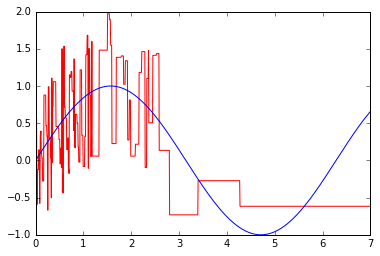

In [34]:
plt.plot(linspace, pred, c = 'r')
plt.plot(linspace, f(linspace))

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

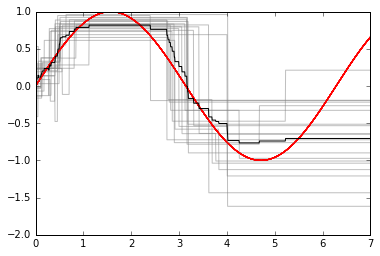

In [69]:
preds = np.zeros([20,1000])
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    u = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + u
    dtr.fit(x[:, np.newaxis], y)
    pred = dtr.predict(linspace[:, np.newaxis])
    preds[i] = pred
    plt.plot(linspace, pred, color="gray", alpha=0.5)
    plt.plot(linspace, f(linspace), color="red")
plt.plot(linspace, preds.mean(axis = 0), color="black")

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

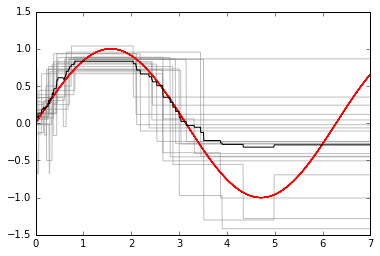

In [68]:
dtr = DecisionTreeRegressor(max_depth=2)
preds = np.zeros([20,1000])
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    u = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + u
    dtr.fit(x[:, np.newaxis], y)
    pred = dtr.predict(linspace[:, np.newaxis])
    preds[i] = pred
    plt.plot(linspace, pred, color="gray", alpha=0.5)
    plt.plot(linspace, f(linspace), color="red")
plt.plot(linspace, preds.mean(axis = 0), color="black")
        

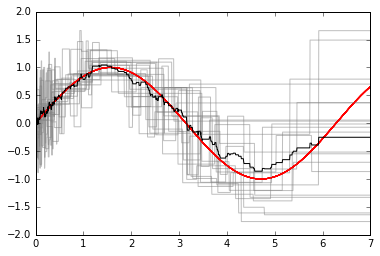

In [67]:
dtr = DecisionTreeRegressor(max_depth=4)
preds = np.zeros([20,1000])
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    u = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + u
    dtr.fit(x[:, np.newaxis], y)
    pred = dtr.predict(linspace[:, np.newaxis])
    preds[i] = pred
    plt.plot(linspace, pred, color="gray", alpha=0.5)
    plt.plot(linspace, f(linspace), color="red")
plt.plot(linspace, preds.mean(axis = 0), color="black")

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

(・・ ) ?



__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

/Users/tata/anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


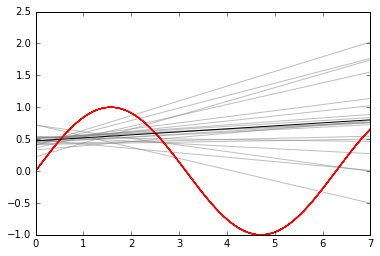

In [73]:
lin = LinearRegression()
preds = np.zeros([20,1000])
for i in range(samples_num):  
    x = np.random.exponential(size = sample_size)
    u = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + u
    lin.fit(x[:, np.newaxis], y)
    pred = lin.predict(linspace[:, np.newaxis])
    preds[i] = pred
    plt.plot(linspace, pred, color="gray", alpha=0.5)
    plt.plot(linspace, f(linspace), color="red")
plt.plot(linspace, preds.mean(axis = 0), color="black")

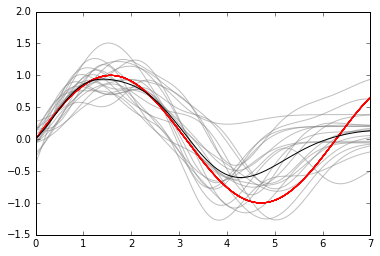

In [74]:
svr = SVR(kernel='rbf', gamma=1)
preds = np.zeros([20,1000])
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    u = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + u
    svr.fit(x[:, np.newaxis], y)
    pred = svr.predict(linspace[:, np.newaxis])
    preds[i] = pred
    plt.plot(linspace, pred, color="gray", alpha=0.5)
    plt.plot(linspace, f(linspace), color="red")
plt.plot(linspace, preds.mean(axis = 0), color="black")

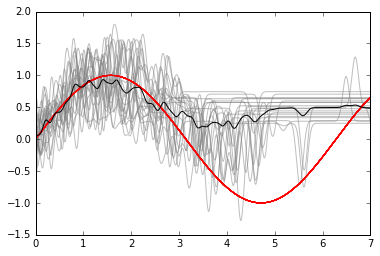

In [75]:
svr = SVR(kernel='rbf', gamma=100)
preds = np.zeros([20,1000])
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    u = np.random.uniform(-1, 1, size = sample_size)
    y = f(x) + u
    svr.fit(x[:, np.newaxis], y)
    pred = svr.predict(linspace[:, np.newaxis])
    preds[i] = pred
    plt.plot(linspace, pred, color="gray", alpha=0.5)
    plt.plot(linspace, f(linspace), color="red")
plt.plot(linspace, preds.mean(axis = 0), color="black")

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [76]:
import pandas as pd

In [89]:
mush = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
                   header = None)
tic = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data",
                  header = None)
cars = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
                   header = None)
nursery = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data",
                      header = None)

In [94]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

У данных есть категориальные, а есть ординальные признаки.
ЕСли все признаки кодировать как обычные категориальльные, то потеряется куча инфы

(・・ ) ?


### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [115]:
df = pd.read_csv("winequality-red.csv", sep = ';')

In [133]:
X.shape

(1599, 11)

In [117]:
y = df["quality"]
X = df.drop("quality", axis = 1)

In [136]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [162]:
dtc = DecisionTreeClassifier()
bc1 = BaggingClassifier(n_estimators=100)
bc2 = BaggingClassifier(n_estimators=100, max_samples=0.5)
rf = RandomForestClassifier(n_estimators=100)

In [159]:
def quality(func):
    a = cross_val_score(func, X, y, scoring='accuracy')
    a = [i for i in a]
    print("Качество на кросс-валидации %a, ср. = %a" % (a, np.mean(a)))

In [170]:
quality(dtc)

Качество на кросс-валидации [0.44672897196261685, 0.42401500938086306, 0.4632768361581921], ср. = 0.44467360583389065


In [171]:
quality(bc1)

Качество на кросс-валидации [0.51401869158878499, 0.57973733583489684, 0.58380414312617701], ср. = 0.55918672351661958


In [172]:
quality(bc2)

Качество на кросс-валидации [0.53457943925233642, 0.57410881801125702, 0.61205273069679844], ср. = 0.57358032932013059


In [173]:
quality(rf)

Качество на кросс-валидации [0.51214953271028041, 0.58724202626641653, 0.59887005649717517], ср. = 0.56608720515795741


#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [194]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)

In [205]:
trees = np.arange(100, 5001, 100)

In [ ]:
acc = np.zeros(50)

In [ ]:
rcf = RandomForestClassifier(n_estimators=trees[0], warm_start=1)

In [196]:
rcf.fit(X_train, y_train)
y_pred = rcf.predict(X_test)
acc[0] = accuracy_score(y_test, y_pred)

In [201]:
for i in trees[1:]:
    rcf.set_params(n_estimators = i)
    rcf.fit(X_train, y_train)
    y_pred = rcf.predict(X_test)
    ind = int((i-100)/100)
    acc[ind] = accuracy_score(y_test, y_pred)

/Users/tata/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:303: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


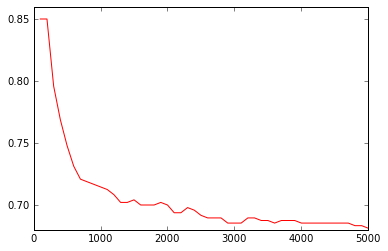

In [211]:
plt.plot(trees, acc, c = 'r')

In [207]:
np.max(acc)

0.84999999999999998

In [209]:
trees[np.argmax(acc)]

100

Случайный лес ооочень сильно переобучаются, лучшее качество при 100 деревьях 

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [307]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [308]:
x_train.shape

(60000, 28, 28)

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [338]:
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential

In [254]:
import keras

In [309]:
x_train = x_train.reshape(60000, 28*28)

In [310]:
x_test = x_test.reshape(10000, 28*28)

In [311]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [312]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [250]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(784,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [277]:
model.compile(optimizer='adam', loss="mse", metrics = ['accuracy'])

In [278]:
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 43s 714us/step - loss: 0.0010 - acc: 0.9940 - val_loss: 0.0041 - val_acc: 0.9773
Epoch 2/10
60000/60000 [==============================] - 26s 425us/step - loss: 9.8414e-04 - acc: 0.9944 - val_loss: 0.0041 - val_acc: 0.9770
Epoch 3/10
60000/60000 [==============================] - 22s 359us/step - loss: 0.0010 - acc: 0.9940 - val_loss: 0.0040 - val_acc: 0.9774
Epoch 4/10
60000/60000 [==============================] - 34s 564us/step - loss: 9.2612e-04 - acc: 0.9947 - val_loss: 0.0040 - val_acc: 0.9776
Epoch 5/10
60000/60000 [==============================] - 28s 459us/step - loss: 9.8996e-04 - acc: 0.9944 - val_loss: 0.0042 - val_acc: 0.9770
Epoch 6/10
60000/60000 [==============================] - 24s 394us/step - loss: 9.7159e-04 - acc: 0.9945 - val_loss: 0.0041 - val_acc: 0.9776
Epoch 7/10
54752/60000 [==========================>...] - ETA: 3s - loss: 9.7603e-04 - acc: 0.9946- 

ValueError: I/O operation on closed file

In [286]:
from sklearn.metrics import accuracy_score
score_keras = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 44us/step


In [288]:
print("accuracy =", score_keras[1])

accuracy = 0.9749


__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [330]:
model1 = Sequential()

In [315]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28,28, 1)

In [331]:
model1.add(Conv2D(32, kernel_size=(5, 5), strides = (1,1), activation='relu', input_shape=(28,28,1)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, (5, 5), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(10, activation='softmax'))

In [333]:
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model1.fit(x_train, y_train, epochs = 3, validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1290      
Total para

In [334]:
score_keras = model1.evaluate(x_test, y_test)

10000/10000 [==============================] - 17s 2ms/step


In [335]:
print("accuracy =", score_keras[1])

accuracy = 0.9898


Еще пару эпох и все будет шикарно! Времени совсем нет :С

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [336]:
model2 = Sequential()

In [339]:
model.add(Dropout(0.5))
model2.add(Conv2D(32, kernel_size=(5, 5), strides = (1,1), activation='relu', input_shape=(28,28,1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64, (5, 5), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

In [340]:
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model1.fit(x_train, y_train, epochs = 3, validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1290      
Total para

KeyboardInterrupt: 

Dropout нужен для того, чтобы избежать переобучения. Мы выкидываем наблюдение с вероятностью 0.5 и нейронка больше не учится только на каких-то супер-объектах больше всего/ на их комбинациях.

ого, какое accuracy! шикарно! (как раз больше 0.99 для предыдущего пункта)

Я, как всегда, затянула, поэтому не везде все эпохи пройдены